
## 05 Hyperparameter Tuning
**Objetivo**: Optimizar los hiperparámetros del modelo seleccionado.
**Contenido**:
- Uso de técnicas como Grid Search y Random Search.
- Evaluación del rendimiento del modelo optimizado.


In [ ]:
!pip install tqdm


In [ ]:
## Importar librerías
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, cv=5):
    # Asegúrate de que y_train y y_val sean vectores unidimensionales
    y_train = np.ravel(y_train)
    y_val = np.ravel(y_val)

    # Validación cruzada en el conjunto de entrenamiento
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)

    # Calcular métricas de validación cruzada
    accuracy_cv = cv_scores.mean()
    roc_auc_cv = roc_auc_score(y_train, y_train_pred_cv)

    # Imprimir métricas de validación cruzada
    print(f'Accuracy (CV): {accuracy_cv:.4f}')
    print(f'ROC AUC (CV): {roc_auc_cv:.4f}')
    print('Classification Report (CV):')
    print(classification_report(y_train, y_train_pred_cv))

    # Mostrar la matriz de confusión promediada
    conf_matrix_cv = confusion_matrix(y_train, y_train_pred_cv)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_cv, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (CV)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Entrenar el modelo con los datos de entrenamiento completos
    model.fit(X_train, y_train)

    # Predecir con los datos de validación
    y_val_pred = model.predict(X_val)

    # Calcular métricas en el conjunto de validación
    accuracy_val = accuracy_score(y_val, y_val_pred)
    roc_auc_val = roc_auc_score(y_val, y_val_pred)

    # Imprimir métricas del conjunto de validación
    print(f'Accuracy (Validation): {accuracy_val:.4f}')
    print(f'ROC AUC (Validation): {roc_auc_val:.4f}')
    print('Classification Report (Validation):')
    print(classification_report(y_val, y_val_pred))

    # Mostrar la matriz de confusión del conjunto de validación
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Retornar el modelo entrenado
    return model

In [ ]:
## Importamos las librerias a usar
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection'


Mounted at /content/drive


## Cargar dataset de entranamiento y evaluación

In [ ]:
# Guardar X y y en archivos CSV

#dir_data_processed = '../data/processed'
dir_data_processed = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/processed'
ruta_archivo_X_train = os.path.join(dir_data_processed, 'X__train_procesados.csv')
ruta_archivo_X_val = os.path.join(dir_data_processed, 'X_val_procesados.csv')

ruta_archivo_y_train = os.path.join(dir_data_processed, 'y_train_procesados.csv')
ruta_archivo_y_val = os.path.join(dir_data_processed, 'y_val_procesados.csv')


X_train_final= pd.read_csv(ruta_archivo_X_train)
X_val_final= pd.read_csv(ruta_archivo_X_val)


y_train_final= pd.read_csv(ruta_archivo_y_train)
y_val_final= pd.read_csv(ruta_archivo_y_val)




### Balanceo de muestra

In [ ]:
## Balanceo de X_train y y_train totales
undersampler = RandomUnderSampler(random_state=42)
X_train_B, y_train_B,= undersampler.fit_resample(X_train_final, y_train_final)
# Mostrar la distribución de clases después del submuestreo
X_train_B.shape, y_train_B.shape

((9716, 184), (9716, 1))

In [ ]:
unique, counts = np.unique(y_train_B, return_counts=True)

# Crear un diccionario para mostrar los resultados
value_counts = dict(zip(unique, counts))
print(value_counts)


{0: 4858, 1: 4858}


In [ ]:
dir_data_preprocessing='/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/preprocessing_objects'
pca = joblib.load(os.path.join(dir_data_preprocessing, 'pca.joblib'))
X_train_pca_B = pca.transform(X_train_B)
X_val_pca = pca.transform(X_val_final)

## Definir el modelo base

In [ ]:

rf = RandomForestClassifier(random_state=42)
#y_train = y_train_B.values.ravel()
y_train = y_train_B
y_val = y_val_final.values.ravel()

## Entrenar y ajustar hiperparámetros

In [ ]:
start_time = time.time()
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# 5. Configurar Grid Search con la métrica AUC y verbose para ver el progreso
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)

# 6. Ajustar el modelo usando Grid Search
# Uso de tqdm para crear una barra de progreso
total_combinations = (len(param_grid['n_estimators']) *
                      len(param_grid['max_features']) *
                      len(param_grid['max_depth']) *
                      len(param_grid['min_samples_split']) *
                      len(param_grid['min_samples_leaf']) *
                      len(param_grid['bootstrap']) * 3)

with tqdm(total=total_combinations) as pbar:
    for _ in grid_search.fit(X_train_pca_B, y_train).cv_results_['mean_test_score']:
        pbar.update(1)

# 7. Evaluar el mejor modelo encontrado con Grid Search
best_grid = grid_search.best_estimator_
y_pred_grid = best_grid.predict(X_val_pca)
y_pred_proba_grid = best_grid.predict_proba(X_val_pca)[:, 1]

print("Mejores Hiperparámetros de Grid Search:", grid_search.best_params_)
print("Exactitud en el conjunto de prueba (Grid Search):", accuracy_score(y_val, y_pred_grid))
print("AUC en el conjunto de prueba (Grid Search):", roc_auc_score(y_val, y_pred_proba_grid))
print("\nReporte de Clasificación (Grid Search):\n", classification_report(y_val, y_pred_grid))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo de entrenamiento fue de {elapsed_time:.2f} segundos")

  0%|          | 0/432 [00:00<?, ?it/s]

Fitting 3 folds for each of 144 candidates, totalling 432 fits


 33%|███▎      | 144/432 [1:18:28<2:36:56, 32.69s/it]  


Mejores Hiperparámetros de Grid Search: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Exactitud en el conjunto de prueba (Grid Search): 0.8290250043243451
AUC en el conjunto de prueba (Grid Search): 0.8931075182095752

Reporte de Clasificación (Grid Search):
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     50990
           1       0.09      0.79      0.16      1041

    accuracy                           0.83     52031
   macro avg       0.54      0.81      0.53     52031
weighted avg       0.98      0.83      0.89     52031

El tiempo de entrenamiento fue de 4717.57 segundos


Mejores Hiperparámetros de Grid Search: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

In [ ]:
start_time = time.time()
# 8. Definir el espacio de búsqueda de hiperparámetros para Random Search
# Usamos los mejores parámetros encontrados por Grid Search como puntos de referencia
param_dist = {
    'n_estimators': [x for x in range(max(10, grid_search.best_params_['n_estimators'] - 200), grid_search.best_params_['n_estimators'] + 200, 50)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [x for x in range(max(1, grid_search.best_params_['max_depth'] - 30), grid_search.best_params_['max_depth'] + 30, 10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 9. Configurar Random Search con la métrica AUC y verbose para ver el progreso
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=3, scoring='roc_auc', verbose=2, random_state=42, n_jobs=-1)

# 10. Ajustar el modelo usando Random Search
# Uso de tqdm para crear una barra de progreso
with tqdm(total=random_search.n_iter * 3) as pbar:
    for _ in random_search.fit(X_train_pca_B, y_train).cv_results_['mean_test_score']:
        pbar.update(1)

# 11. Evaluar el mejor modelo encontrado con Random Search
best_random = random_search.best_estimator_
y_pred_random = best_random.predict(X_val_pca)
y_pred_proba_random = best_random.predict_proba(X_val_pca)[:, 1]

print("Mejores Hiperparámetros de Random Search:", random_search.best_params_)
print("Exactitud en el conjunto de prueba (Random Search):", accuracy_score(y_val, y_pred_random))
print("AUC en el conjunto de prueba (Random Search):", roc_auc_score(y_val, y_pred_proba_random))
print("\nReporte de Clasificación (Random Search):\n", classification_report(y_val, y_pred_random))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo de entrenamiento fue de {elapsed_time:.2f} segundos")

  0%|          | 0/300 [00:00<?, ?it/s]

Fitting 3 folds for each of 100 candidates, totalling 300 fits


 33%|███▎      | 100/300 [1:26:07<2:52:14, 51.67s/it]  


Mejores Hiperparámetros de Random Search: {'n_estimators': 650, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
Exactitud en el conjunto de prueba (Random Search): 0.8296015836712729
AUC en el conjunto de prueba (Random Search): 0.893477154266748

Reporte de Clasificación (Random Search):
               precision    recall  f1-score   support

           0       0.99      0.83      0.91     50990
           1       0.09      0.79      0.16      1041

    accuracy                           0.83     52031
   macro avg       0.54      0.81      0.53     52031
weighted avg       0.98      0.83      0.89     52031



Mejores Hiperparámetros de Random Search: {'n_estimators': 650, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}

Accuracy (CV): 0.8063
ROC AUC (CV): 0.8056
Classification Report (CV):
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      4858
           1       0.81      0.80      0.80      4858

    accuracy                           0.81      9716
   macro avg       0.81      0.81      0.81      9716
weighted avg       0.81      0.81      0.81      9716



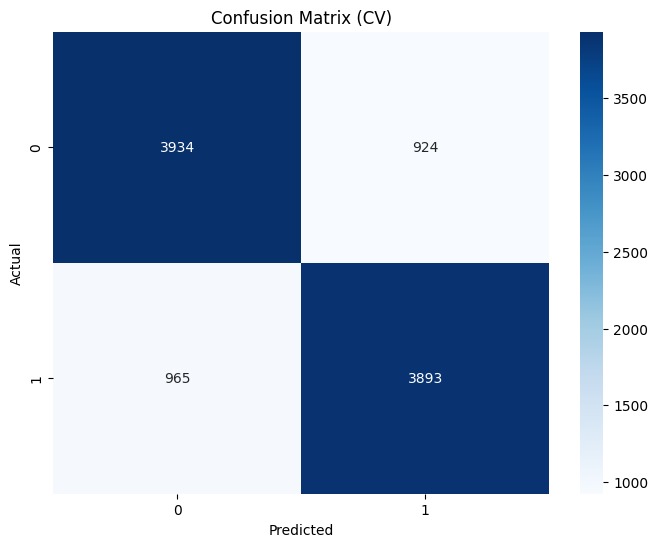

Accuracy (Validation): 0.8299
ROC AUC (Validation): 0.8078
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.83      0.91     50990
           1       0.09      0.78      0.16      1041

    accuracy                           0.83     52031
   macro avg       0.54      0.81      0.53     52031
weighted avg       0.98      0.83      0.89     52031



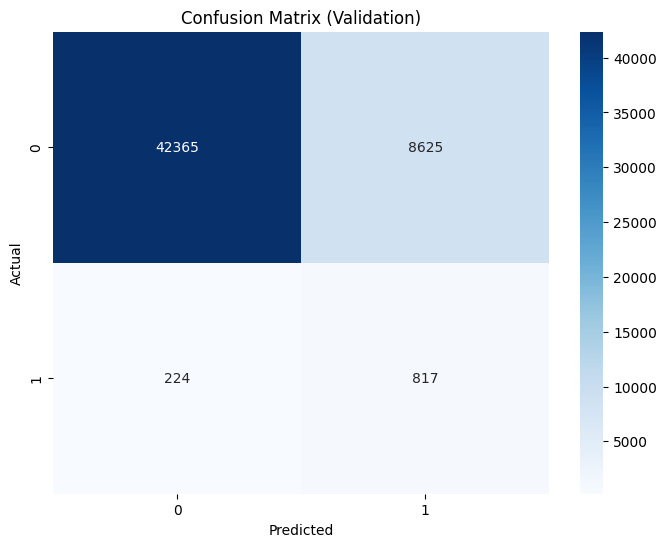

In [ ]:

params = {
    'n_estimators': 650,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'max_depth': 40,
    'bootstrap': False
}

# Creación del clasificador con los parámetros especificados
rf_clf_best = RandomForestClassifier(**params)
rf_clf_best = train_and_evaluate_model(rlf_clf_best , X_train_pca_B, y_train_B, X_val_pca_B, y_val_final)

Combinamos Grid Search y Random Search para explorar de manera exhaustiva y eficiente el espacio de hiperparámetros. Utilizamos Grid Search inicialmente para realizar una búsqueda amplia de hiperparámetros, seguida de Random Search para refinar y buscar de manera más precisa dentro de las regiones prometedoras identificadas.

## Evaluar el modelo optimizado

In [ ]:
# Directorio para guardar el modelo
dir_data_models = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/models'
ruta_archivo_model = os.path.join(dir_data_models, 'modelo_rf_clf_best.joblib')

# Guardar el modelo
joblib.dump(rf_clf_best, ruta_archivo_model)

['/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/models/modelo_rf_clf_best.joblib']

x_

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

## Utilizando Xgboost como segunda propuesta de modelo

In [ ]:
# param_dist = {
#     'max_depth': [ 10],  # Profundidad máxima del árbol
#     'eta': [ 0.3],     # Tasa de aprendizaje (learning rate)
#     'objective': ['binary:logistic'],      # Función objetivo (clasificación binaria)
#     'eval_metric': ['logloss', 'auc']      # Métricas de evaluación

# }


# random_search = RandomizedSearchCV(
#     estimator=xgb_model,     # Modelo XGBoost
#     param_distributions=param_dist,  # Distribución de parámetros para explorar
#     n_iter=100,              # Número de combinaciones de hiperparámetros a probar
#     cv=5,                    # Número de divisiones para validación cruzada
#     scoring='roc_auc',       # Métrica de evaluación a optimizar (AUC-ROC)
#     n_jobs=-1,               # Número de núcleos para procesos en paralelo, -1 usa todos los disponibles
#     random_state=42          # Semilla para reproducibilidad de resultados
# )

In [ ]:
# grid_search.fit(X_train_resampled, y_train_resampled)
# print("Mejores hiperparámetros encontrados por Grid Search:")
# print(grid_search.best_params_)


In [ ]:
# random_search.fit(X_train_resampled, y_train_resampled)
# print("Mejores hiperparámetros encontrados por Random Search:")
# print(random_search.best_params_)


In [ ]:


# # # Evaluación del modelo con los mejores parámetros encontrados por Grid Search
# # best_grid_model = grid_search.best_estimator_
# # print("Rendimiento del modelo con mejores parámetros (Grid Search):")
# # evaluate_model(best_grid_model, X_test, y_test)

# # Evaluación del modelo con los mejores parámetros encontrados por Random Search
# best_random_model = random_search.best_estimator_
# print("Rendimiento del modelo con mejores parámetros (Random Search):")
# evaluate_model(best_random_model, X_val, y_val)


In [ ]:
# dir_data_processed = '../models'
# ruta_archivo_model = os.path.join(dir_data_processed, 'modelo_xgboost.bin')

# best_random_model.save_model(ruta_archivo_model )

### Conclusión
- Empleamos una combinación de Grid Search y Random Search para explorar exhaustiva y eficientemente el espacio de hiperparámetros. Iniciamos con Grid Search para realizar una búsqueda amplia de hiperparámetros y luego utilizamos Random Search para refinar y explorar de manera más precisa dentro de las regiones prometedoras identificadas.

- Logramos obtener los mejores parámetros para el modelo Random Forest, optimizando así su rendimiento.

- Finalmente, exportamos el modelo entrenado, listo para su implementación y uso en aplicaciones futuras.